In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
df = pd.read_csv('co2_mm_mlo.csv')
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [11]:
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [12]:
df.set_index('date', inplace=True)
df.index.freq='MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


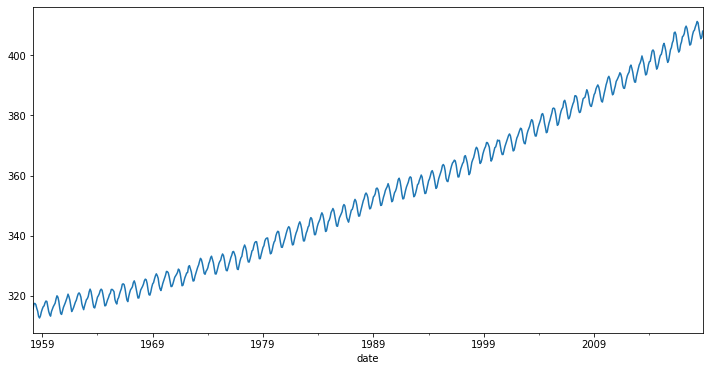

In [13]:
df['interpolated'].plot(figsize=(12,6))

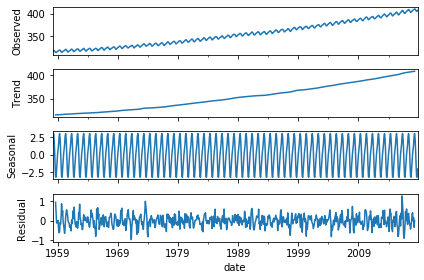

In [15]:
result=seasonal_decompose(df["interpolated"], model='add')
result.plot();

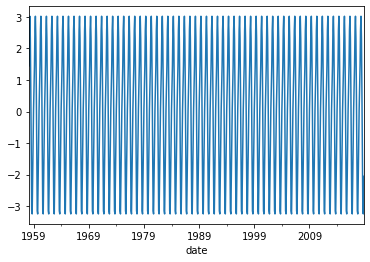

In [17]:
result.seasonal.plot()

In [24]:
stepwise_fit = auto_arima(df['interpolated'], max_order=6, d=1, D=1, m=12, max_p=2, max_q=3, max_P=1, max_Q=1, 
                          stepwise=False, trace=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=375.876, BIC=412.465, Fit time=11.818 seconds
Total fit time: 11.820 seconds


In [20]:
train = df.iloc[:717]
test = df.iloc[717:]

In [22]:
#ARIMA(1,1,1)x(0,1,1,12)
model = SARIMAX(train['interpolated'], order=(1,1,1), seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -180.357
Date:                            Tue, 26 May 2020   AIC                            368.714
Time:                                    17:45:21   BIC                            386.941
Sample:                                03-01-1958   HQIC                           375.758
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2005      0.082      2.444      0.015       0.040       0.361
ma.L1         -0.5632      0.071     -7.927      0.000      -0.702      -0.424
ma.S.L12      -0.8636      0.022    -38.963      0.000      -0.907      -0.820
sigma2         0.0955      0.005     20.424      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       42.85   Jarque-Bera (JB):                 4.95
Prob(Q):                              0.35   Prob(JB):                         0.08
Heteroskedasticity (H):               1.13   Skew:                             0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1, 1, 1)x(0, 1, 1, 12) Predictions')

In [28]:
predictions.head()

2017-12-01    406.607287
2018-01-01    407.824772
2018-02-01    408.573821
2018-03-01    409.482183
2018-04-01    411.047600
Freq: MS, Name: SARIMA(1, 1, 1)x(0, 1, 1, 12) Predictions, dtype: float64

[Text(0, 0.5, 'Parts per milion'), Text(0.5, 0, 'Date')]

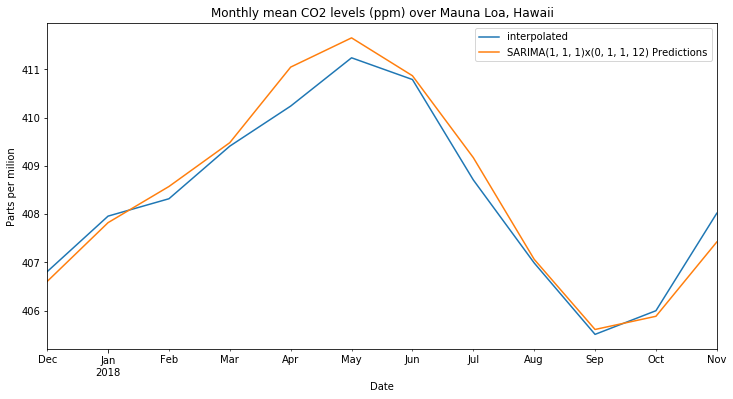

In [29]:
title='Monthly mean CO2 levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'Parts per milion'
xlabel = 'Date'

ax = test['interpolated'].plot(legend=True, figsize=(12,6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [30]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test['interpolated'], predictions)
print(error)

0.12957526678196818


In [33]:
from statsmodels.tools.eval_measures import rmse
rmseError = rmse(test['interpolated'], predictions)
print(rmseError)

0.35996564666919006


In [34]:
model = SARIMAX(df['interpolated'], order=(1,1,1), seasonal_order=(0,1,1,12))
results = model.fit()
forecast = results.predict(len(df), len(df)+11).rename('SARIMA Forecast')

[Text(0, 0.5, 'Parts per milion'), Text(0.5, 0, 'Date')]

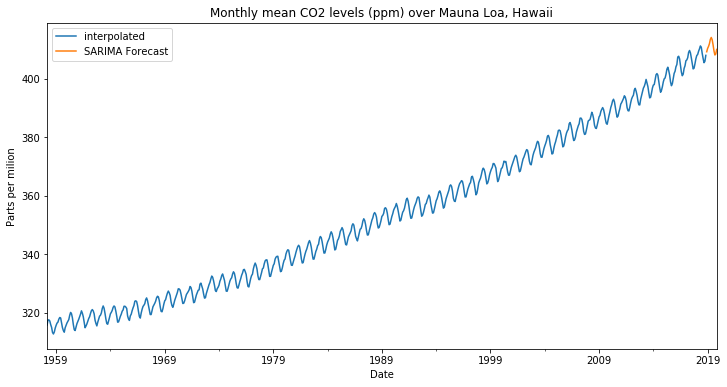

In [35]:
title='Monthly mean CO2 levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'Parts per milion'
xlabel = 'Date'

ax = df['interpolated'].plot(legend=True, figsize=(12,6), title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)